<h1 >**Data Mining Project Spring 2020**</h1>
<p>The purpose of the term project is to predict the ratings given a particular review. Throughout the implementation of the term project many models were tested and based on the various evaluation metrics a model was selected. The dataset is taken from Kaggle BGG review dataset . Due to the vast length of dataset Google Colaboratory was used as the implementation platform<p>

In [1]:
#Linking colab to google drive where the dataset is saved
from google.colab import drive
import zipfile
#Mount the drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Extracting tar file using zipfile module. We have a huge dataset (around 13 million rows)

In [0]:
zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/Colab Notebooks/bgg-13m-reviews.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

<p> Importing the necessary libraries </p>

In [0]:
import numpy as np
import pandas as pd
import string 
import re 
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

Specifying the path where the csv file is stored

In [0]:
path='/tmp/bgg-13m-reviews.csv'

Reading the csv file as a data frame using the pandas module.In the read_csv we can specify nrows which indicates how many rows need to be read

In [0]:
df = pd.read_csv(path, delimiter=',')
nRow, nCol = df.shape
#print(f'There are {nRow} rows and {nCol} columns')

The first part of the project is just analysis of the data file to see how the ratings class is spread. The spread is quite lobsided toward a seven rating which is tackled later in the notebook. Textual data like the comment section of the BGG requires a considerable ammount of preprocessing. Cleaning techniques like removal of punctuation, returing string.lower() and removal of NaN values is used. 

In [0]:
df=df.dropna()
#print(df.count())

Seeing how our data frame looks like.The two main columns we are going to use in the project are comment and rating.

In [7]:
df.head()

,Unnamed: 0,user,rating,comment,ID,name
2,2,dougthonus,10.0,"Currently, this sits on my list as my favorite...",13,Catan
3,3,cypar7,10.0,"I know it says how many plays, but many, many ...",13,Catan
7,7,hreimer,10.0,i will never tire of this game.. Awesome,13,Catan
11,11,daredevil,10.0,This is probably the best game I ever played. ...,13,Catan
16,16,hurkle,10.0,Fantastic game. Got me hooked on games all ove...,13,Catan


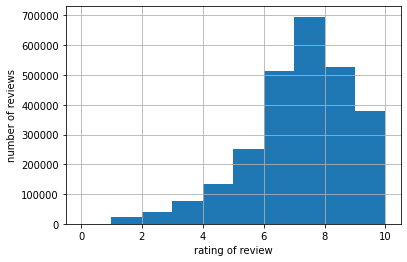

In [6]:
df['rating'].hist(bins=10)
plt.xlabel('rating of review')
plt.ylabel('number of reviews')
plt.show()

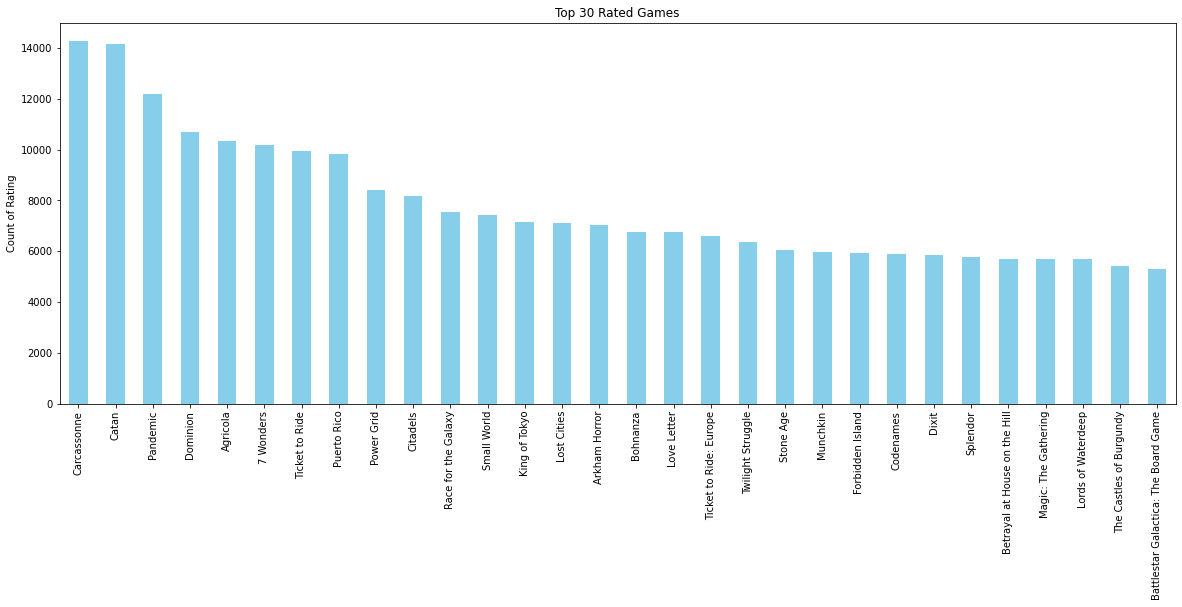

In [7]:
plt.figure(figsize=(20, 7))
df['name'].value_counts()[:30].plot(kind='bar',color="skyblue")
plt.ylabel('Count of Rating')
plt.title('Top 30 Rated Games')
plt.show()

In [0]:
from nltk.corpus import stopwords
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS

Preprocessing the text. We remove white spaces, punctuations, stopwords and make the string lowercase

In [0]:
def remove_noise(text):
    
    text = text.apply(lambda x: " ".join(x.lower() for x in x.split()))
    
    text = text.apply(lambda x: " ".join(x.strip() for x in x.split()))
    
    text = text.str.replace('[^\w\s]', '')

    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
        
    return text
df['comment'] = remove_noise(df['comment'])

Checking the dataframe after cleaning

In [10]:
df.head()
#print(df.info())

,Unnamed: 0,user,rating,comment,ID,name
2,2,dougthonus,10.0,currently sits list favorite game,13,Catan
3,3,cypar7,10.0,know says plays uncounted liked version best,13,Catan
7,7,hreimer,10.0,tire game awesome,13,Catan
11,11,daredevil,10.0,probably best game played requires just thinki...,13,Catan
16,16,hurkle,10.0,fantastic game got hooked games,13,Catan


In [0]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['comment'], 30)
for word, freq in common_words:
    #print(word, freq)
  df2 = pd.DataFrame(common_words, columns = ['ReviewText' , 'count'])
#df2.groupby('ReviewText').sum()['count'].sort_values(ascending=False).iplot(
#kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in review after removing stop words')


As we can see , after removing the stopwords these are our top 30 words

In [112]:
df2

,ReviewText,count
0,game,2539119
1,play,743697
2,like,520940
3,fun,517789
4,good,398781
5,games,392353
6,players,369127
7,really,359752
8,played,353415
9,great,329474


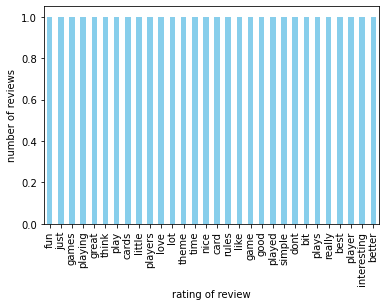

In [120]:
df2['ReviewText'].value_counts()[:30].plot(kind='bar',color="skyblue")
plt.xlabel('rating of review')
plt.ylabel('number of reviews')
plt.show()

In [0]:
#counting the number of ratings to each number
from collections import Counter
rate = df['rating'].values
rate=rate.astype(int)

Our data is arranged such that all the ratings are in ascending order thus we need to shuffle the data before splitting into training and test sets

In [0]:
df = df.sample(frac=1).reset_index(drop=True)

In [44]:
df1=df.sample(n=16000)
print(df1.count())

Unnamed: 0    16000
user          16000
rating        16000
comment       16000
ID            16000
name          16000
dtype: int64


Assigning 'x' to the comment section and 'y' to the rating section of our data frame

In [0]:
x=df1['comment'].values
y=np.round(df1['rating'].values)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

Just a look at how our X_test looks. We need to vectorise the data because ML models require vector represenation of texts

In [47]:
X_test

array(['solo good players 8 3 players 65 4 players unplayable like wheel whitout classic boring card game unfortunately like control strategy play game player 34 uncontrollable strongly recommend play excellent materials',
       'old town solo',
       'neutral occasion huge toyparty value good production quality game merely ok feels like doesnt realize potentialof game idea suspect replayability novelty value',
       ...,
       'fun chillout warmup game simple rules allow quick learnasyouplay plenty replayability character significantly overpowering decent strategy simple game fun ages issue game elimination player left watch rest battle code fairplay fun stopping ganging single character player sit rest gametime',
       'auction',
       'great light dexterity game play kids definitely takes skill especially lanes like shallow troughs instead flat game equalized somewhat played 4 players making lane longer different ways play game nice supports 24 players'],
      dtype=object)

For textutal data to be processed it needs to be coverted into a vector matrix representation.But just calculating the count(or frequency) of the terms might result in percieving all the terms as equally important. The TF-IDF vectorizer attenuates the terms whose occurence is common and not of much relevance and gives importance to more relevant terms.Mathematically speaking Tf is ratio of number of times a word occurred in a document to the total number of words in the document. and IDF is the log of total docs divided by docs containing the word.

![alt text](https://www.joyofdata.de/blog/wp-content/uploads/2014/02/tf-idf.png)

Vectorising the data 

In [0]:
vect = TfidfVectorizer(stop_words = 'english',max_df=0.7,max_features=10000)
x_train_cv = vect.fit_transform(X_train)
x_test_cv = vect.transform(X_test)

Trying of the different ML modules now 

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.externals import joblib
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [98]:
accuracy_all=[]
print(accuracy_all)

[]


Our first model is Multinomial Naive Bayes.
One of the most simple Naive Bayes model is the Gaussian Naive Bayes model because it works under the assumption that the data is decribed by the Gaussian distribution but there is also Multinomial Naive Bayes that can be used to get the generative distribution within each label.Here the features are assumed to be generated from a simple multinomia distribution. It is suitale for features that have counts(like ratings in our data) because it describes the probability of observing count among number of various categories.

$$
P(c|d) =P(c) \prod_{k=1}^n P(t_k|c)
$$

In [51]:
#Implementing MultinomialNB
model = MultinomialNB()
model.fit(x_train_cv, y_train.astype('int'))
value = model.predict(x_test_cv)
accuracy_NB=accuracy_score(y_test,value)
print("accuracy of Naive Bayes",accuracy_NB)

accuracy of Naive Bayes 0.2914583333333333


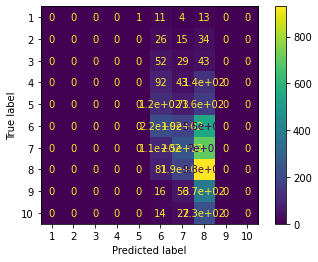

In [53]:

disp=plot_confusion_matrix(model, x_test_cv, y_test)

The next model we use is the Support Vector Machine methodolgy. SVM model is mostly used for discriminative classification as opposed to generative classification.We use the scikit learns SVM module to train our model.

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/300px-SVM_margin.png)

In [54]:
svm= SVC(kernel='linear',probability=True)
svm.fit(x_train_cv,y_train)
pred=svm.predict(x_test_cv)
accuracy_svm=accuracy_score(y_test,pred)
print("Accuracy of the SVC model:",accuracy_svm)

Accuracy of the SVC model: 0.2975


The next model we tested is the KNN model. It had the lowest accuracy among all other models.The k-nearest neighbors (KNN) algorithm is a supervised machine learning algorithm that can be used to solve both classification and regression problems.
When we need to make a prediction, the k-most similar neighbors are located and an equivalent prediction is made. It is like forming a “majority vote” between the k most similar instances to a new unobserved instance. Similarity is the distance metric between two data points.

![alt text](https://miro.medium.com/max/800/1*2zYNhLc522h0zftD1zDh2g.png)

In [101]:
kNN = KNeighborsClassifier(n_neighbors=7)
kNN.fit(x_train_cv,y_train)
pred_k = kNN.predict(x_test_cv)
accuracy_knn = accuracy_score(y_test,pred_k)
print('Accuracy of KNN model',accuracy_knn)

Accuracy of KNN model 0.21916666666666668


In [57]:
clf=RidgeClassifier()
clf.fit(x_train_cv,y_train)
pred1=clf.predict(x_test_cv)
accuracy_ridge=accuracy_score(y_test,pred1)
print("Accuracy of the ridge classifier",accuracy_ridge)

Accuracy of the ridge classifier 0.2833333333333333


In [0]:
accuracy_all.append(accuracy_NB)
accuracy_all.append(accuracy_svm)
accuracy_all.append(accuracy_ridge)
accuracy_all.append(accuracy_knn)

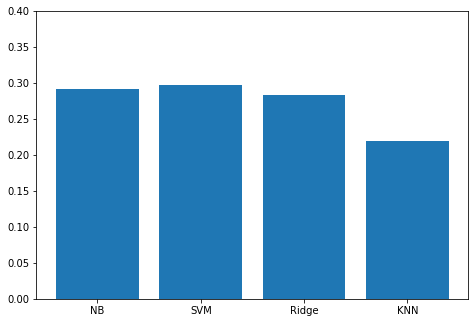

In [103]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['NB', 'SVM', 'Ridge','KNN']
students = accuracy_all
ax.bar(langs,students)
plt.ylim(0,0.4,0.01)
plt.show()

We see that almost all the classifiers have the same accuraccy and even though SVM performs better , it takes a lot of time to process even on small datasets
<h1>Contribution</h1>
Applying smoothing to our classifier and relaxing the problem can get us a better accuracy.
We have a broad range of classes from 1 to 10. Smoothing is applied by allowing a difference of 1 between the predicted and the target classes

In [0]:
def smoothing(predicted,actual):
  counter=0
  for i in range(len(predicted)):
    if(predicted[i]-actual[i]<2):
      counter+=1
  return counter/len(predicted)

In [104]:
acc_nb_smooth=smoothing(value,y_test)
acc_svm_smooth=smoothing(pred,y_test)
acc_ridge_smooth=smoothing(pred1,y_test)
acc_knn_smooth=smoothing(pred_k,y_test)
print(acc_nb_smooth)
print(acc_svm_smooth)
print(acc_ridge_smooth)
print(acc_knn_smooth)

0.7316666666666667
0.7908333333333334
0.78125
0.783125


In [0]:
accuracy_smooth=[]


In [0]:
accuracy_smooth.append(accuracy_NB)
accuracy_smooth.append(acc_nb_smooth)
accuracy_smooth.append(accuracy_svm)
accuracy_smooth.append(acc_svm_smooth)
accuracy_smooth.append(accuracy_ridge)
accuracy_smooth.append(acc_ridge_smooth)
accuracy_smooth.append(accuracy_knn)
accuracy_smooth.append(acc_knn_smooth)

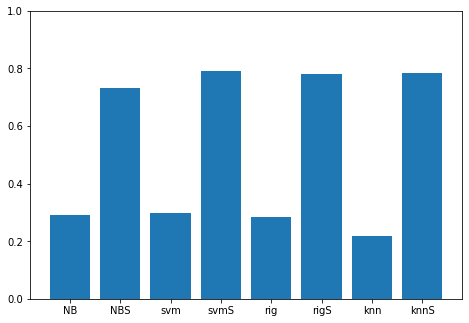

In [114]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['NB','NBS','svm','svmS','rig','rigS','knn','knnS']
students = accuracy_smooth
ax.bar(langs,students)
plt.ylim(0,1)
plt.show()

In [0]:
Ensemble = VotingClassifier(estimators=[('Linear',svm), ('Nb',model)])

In [87]:
Ensemble.fit(x_train_cv,y_train)

VotingClassifier(estimators=[('Linear',
                              SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='scale', kernel='linear', max_iter=-1,
                                  probability=True, random_state=None,
                                  shrinking=True, tol=0.001, verbose=False)),
                             ('Nb',
                              MultinomialNB(alpha=1.0, class_prior=None,
                                            fit_prior=True))],
                 flatten_transform=True, n_jobs=None, voting='hard',
                 weights=None)

In [0]:
e_pred=Ensemble.predict(x_test_cv)

In [93]:
acc3=accuracy_score(e_pred,y_test)
print(acc3)
acc3_smooth=smoothing(e_pred,y_test)
print(acc3_smooth)

0.29854166666666665
0.7979166666666667
